# Retraining
Here we explore the differences between LightGBM and XGBoost in a retraining setting

The two datasets used are a BCI and Airline dataset. 

In [1]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt, curry
import pandas as pd
import os
import io
from IPython.core.display import display, HTML, SVG
from bokeh.io import output_notebook
%matplotlib inline 

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
airline_notebook = '01_airline.ipynb'
bci_notebook = '02_BCI.ipynb'
football_notebook = '03_football.ipynb'

In [4]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [5]:
@curry
def read_cell(cell_key, nb):
    """ Returns code cell that starts with cell_key
    """
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith(cell_key):
            return cell

In [6]:
@curry
def select(output_type, cell_outputs):
    for elem in cell_outputs:
        if elem['output_type']==output_type:
            return elem

In [7]:
@curry
def select_data_type(data_type, output_element):
    return output_element['data'][data_type]

In [8]:
def read_html(cell):
    return pipe(cell['outputs'],
                select('display_data'),
                select_data_type('text/html'),
                HTML,
                display)

In [9]:
def read_svg(cell):
    return pipe(cell['outputs'],
                select('display_data'),
                select_data_type('image/svg+xml'),
                SVG,
                display)

In [10]:
def read_html_from_nb(notebook_name, cell_key):
    """ Reads html from notebook
    """
    return pipe(notebook_name,
                read_notebook,
                read_cell(cell_key),
                read_html)

In [11]:
def read_svg_from_nb(notebook_name, cell_key):
    """ Reads svg from notebook
    """
    return pipe(notebook_name,
                read_notebook,
                read_cell(cell_key),
                read_svg)

## Airline

In this dataset we have data of airline flights for more than 20 years. Training in the first 5 years and evaluating ont the following ones, will give us Accuracy train, plotted in blue. As it can be observed, the accuracy diminished with time. If we retrain with data until 2002 and then evaluate in the following years (green line), the accuracy is higher, almost at the same level as the initial training.

In [12]:
read_html_from_nb(airline_notebook, '# Airline Retrain Results')

In [18]:
read_svg_from_nb(airline_notebook, '# SVG: Airline Retrain Results')

## BCI
In this dataset we likely have a mixture of virtual concept drift and true concept drift. This is due to number of factors including changes in electrode impedance as well as changes to the underlying neural phenomena observed. Since these changes are expected to occur gradually we also expect the concept drift to gradually change. In the example below we naiviley retrain at a regular interval. No effort is carried out to try and select samples to retrain with which would eventually lead to the model learning to model the noise as performance continues to degrade

In [13]:
read_html_from_nb(bci_notebook, '# XGB Retrain Results')

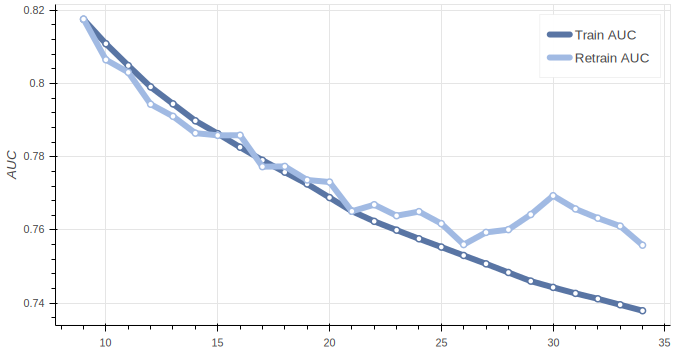

In [14]:
# Render SVG so that it is visible on Github
read_svg_from_nb(bci_notebook, '# SVG: XGB Retrain Results')

In [15]:
read_html_from_nb(bci_notebook, '# LGBM Retrain Results')

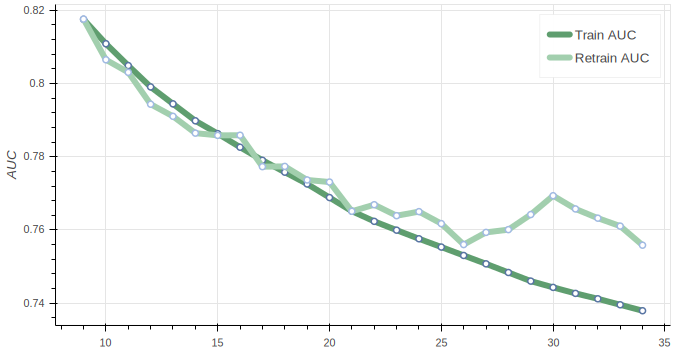

In [16]:
# Render SVG so that it is visible on Github
read_svg_from_nb(bci_notebook, '# SVG: LGBM Retrain Results')

Overall we can see that naive retraining improves performance slightly especially in the later epochs. It also seems that XGBoost is able to achieve a slightly better AUC than LightGBM.

In [56]:
read_html_from_nb(bci_notebook, '# XGB vs LGBM Retrain Time')

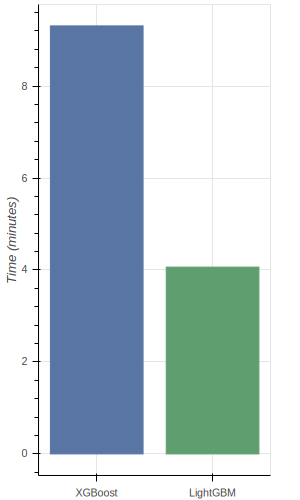

In [57]:
# Render SVG so that it is visible on Github
read_svg_from_nb(bci_notebook, '# SVG: XGB vs LGBM Retrain Time')

Above is the total time taken to run the train retrain experiment. we can see that LightGBM is over twice as fast as XGBoost.

## Football

The football dataset is highly noisy and the metrics are poor. However, we can see the beginnings of concept drift on in. In the plot it is represented the accuracy of both XGBoost and LightGBM libraries under the following conditions: the first label, 2014/2015, represents a model trained on data from 2008 season until 2014, and then evaluated in season 2014/2015. Then the same model is evaluated in season 2015/2016. Finally, the model is retrained with data from 2008 season until 2015 and evaluated in season 2015/2016. As it is shown, the retrained model performs better. 

In [19]:
read_html_from_nb(football_notebook, '# Football Retrain Results')

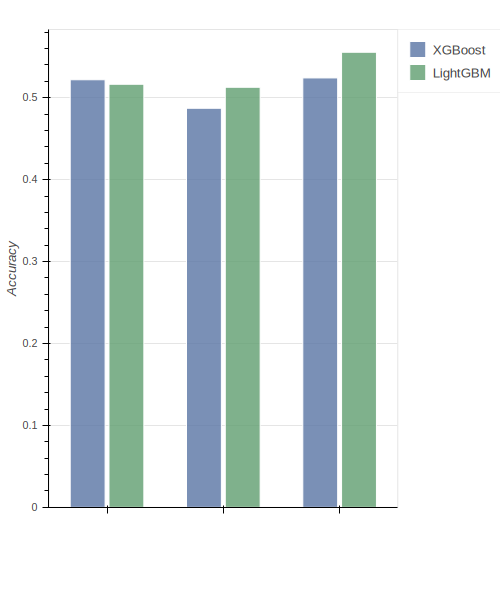

In [20]:
read_svg_from_nb(football_notebook, '# SVG: Football Retrain Results')